# Training a Three-Class Classifier with Active Learning

This notebook provides you with a complete code example that uses active learning to classify points in a plane into three classes.

## Creating a Dataset with Three Groups of Data Points

Create a dataset with three groups of data ...

In [34]:
import numpy as np

gr0 = np.random.normal(loc=(-2.2, 0), scale=(1, 1), size=(150, 2))
gr1 = np.random.normal(loc=(2.2, 0), scale=(1, 1), size=(150, 2))
gr2 = np.random.normal(loc=(0, 2.5), scale=(1, 1), size=(150, 2))

x = np.vstack((gr0, gr1, gr2))
y = np.hstack((np.zeros(len(gr0)), np.ones(len(gr1)), 2 * np.ones(len(gr2))))


... and plot it.

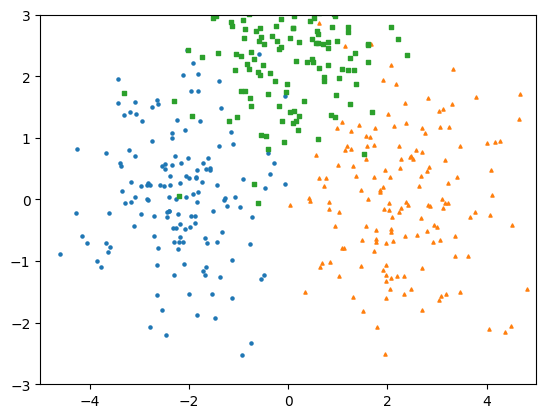

In [35]:
import matplotlib.pyplot as plt

plt.scatter(gr0[:, 0], gr0[:, 1], marker="o", s=5, c="C0")
plt.scatter(gr1[:, 0], gr1[:, 1], marker="^", s=5, c="C1")
plt.scatter(gr2[:, 0], gr2[:, 1], marker="s", s=5, c="C2")
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.savefig("fig_12_05.pdf", bbox_inches='tight')  ### plt.show()

## Implementing the Active Learning Process with Multiple Classes

Implement a function to train and test the model with logistic regression ...

In [36]:
from sklearn.linear_model import LogisticRegression

def train_model(x_train, y_train, x_test, y_test):
    """Find optimal decision boundary using a logistic regression."""
    model = LogisticRegression()
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    return model, accuracy

... a function to perform the active learning for binary classification ...

In [37]:
def train_active_learning(x, y, budget, query):
    """Train multi-class classifier with active learning."""
    annotated_idxs = [np.random.choice(np.where(y == i)[0]) 
                      for i in range(int(y.max()) + 1)]
    unannotated_idxs = np.setdiff1d(np.arange(x.shape[0]), annotated_idxs)

    accuracy_history = []
    for _ in range(budget):
        annotated_x, annotations = x[annotated_idxs], y[annotated_idxs]
        unannotated_x = x[unannotated_idxs]

        model, accuracy = train_model(annotated_x, annotations, x, y)
        accuracy_history.append(accuracy)
        
        idx_to_annotate = query(model, unannotated_x)
        annotated_idxs = np.append(annotated_idxs,
                                   unannotated_idxs[idx_to_annotate])
        unannotated_idxs = np.delete(unannotated_idxs, idx_to_annotate)

    return accuracy_history, model, annotated_idxs

... implement a function to plot the multi-class classification ...

In [38]:
def plot_model3(model, gr0, gr1, gr2, annotated_x, annotations, figname):  ###
    """Plot model decision boundary and annotated data with 3 classes."""
    plt.scatter(gr0[:, 0], gr0[:, 1], marker="o", s=0.5, c="C0")
    plt.scatter(gr1[:, 0], gr1[:, 1], marker="^", s=0.5, c="C1")
    plt.scatter(gr2[:, 0], gr2[:, 1], marker="s", s=1, c="C2")

    is0, is1, is2 = annotations == 0, annotations == 1, annotations == 2
    plt.scatter(annotated_x[is0, 0], annotated_x[is0, 1], 
                marker="o", s=50, c="C0", label="Selected Group 1")
    plt.scatter(annotated_x[is1, 0], annotated_x[is1, 1], 
                marker="^", s=50, c="C1", label="Selected Group 2")
    plt.scatter(annotated_x[is2, 0], annotated_x[is2, 1], 
                marker="s", s=50, c="C2", label="Selected Group 3")

    xx, yy = np.meshgrid(np.linspace(-5, 5, 1000), np.linspace(-3, 3, 1000))
    z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contour(xx, yy, z, levels=[0.5, 1.5], colors="black")
    
    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.legend()
    plt.savefig(figname, bbox_inches='tight')  ### plt.show()

### Random Sampling

Implement a function to select a data point at random ...

In [39]:
def query_random(model, unannotated_x):
    """Select data point to annotate randomly."""
    return np.random.randint(len(unannotated_x))

... and perform active learning.

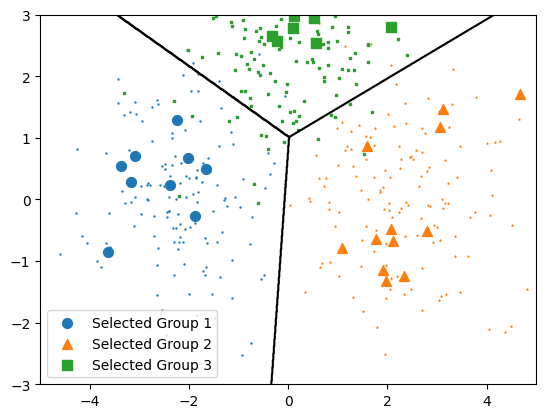

In [40]:
accuracy_random, model_random, idxs_random = \
    train_active_learning(x, y, budget=30, query=query_random)
plot_model3(model_random, gr0, gr1, gr2, x[idxs_random], y[idxs_random], figname="fig_12_06.pdf")  ###

### Uncertainty Sampling

Implement the function to select data with uncertainty sampling ...

In [41]:
def query_uncertainty(model, unannotated_x):
    """Select data point to annotate randomly with uncertainty sampling."""    
    probabilities = model.predict_proba(unannotated_x)
    return np.argmin(np.max(probabilities, axis=1))

... and perform active learning.

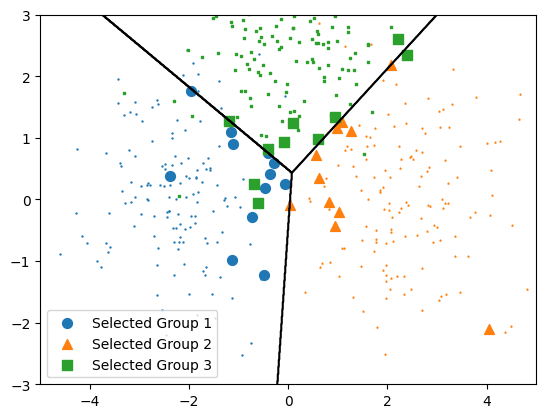

In [42]:
accuracy_uncertainty, model_uncertainty, idxs_uncertainty = \
    train_active_learning(x, y, budget=30, query=query_uncertainty)
plot_model3(model_uncertainty, gr0, gr1, gr2, 
            x[idxs_uncertainty], y[idxs_uncertainty], figname="fig_12_07.pdf")  ###

## Comparing Sampling Strategies

Calculate the average accuracy for multi-class classification ...

In [43]:
trials = 100

accuracy_histories_random, accuracy_histories_uncertainty = [], []
for i in range(trials):
    accuracy_history_random, *_ = \
        train_active_learning(x, y, budget=30, query=query_random)
    accuracy_histories_random.append(accuracy_history_random)
    
    accuracy_history_uncertainty, *_ = \
        train_active_learning(x, y, budget=30, query=query_uncertainty)
    accuracy_histories_uncertainty.append(accuracy_history_uncertainty)

... and plot the average accuracy as a function of annotations over multiple trials.

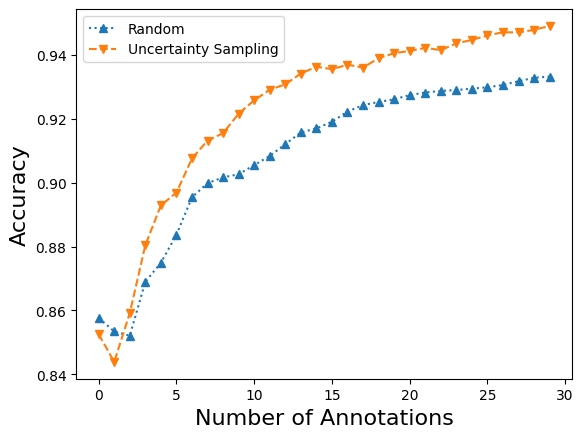

In [44]:
plt.plot(np.mean(accuracy_histories_random, axis=0), "^:", label="Random")
plt.plot(np.mean(accuracy_histories_uncertainty, axis=0), "v--", 
         label="Uncertainty Sampling")
plt.xlabel("Number of Annotations", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend()
plt.savefig("fig_12_08.pdf", bbox_inches='tight')  ### plt.show()